In [1]:
import pandas as pd
import numpy as np
import os
import re

In [2]:
# Loading Data
data = pd.read_csv("./sample_data/spam_ham_dataset.csv")

In [3]:
data.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [4]:
data = data.drop(['Unnamed: 0'],axis=1)

In [5]:
X = data['text']
Y = data['label_num']

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
def preprocess_text(data):
  # Removing special characters and Numericals
  data = [re.sub(r"[^a-zA-Z]+", ' ', text) for text in data]
  # Tokenizing the words
  data = [word_tokenize(text) for text in data]
  # Removing stopwords
  data = [' '.join(list(filter(lambda x:x not in stopwords.words(),record))) for record in data] 
  return data

In [8]:
X_preprocessed = preprocess_text(X)

In [20]:
data['Processed Text'] = X_preprocessed

In [21]:
data.to_csv("Processed.csv")

In [23]:
data = pd.read_csv("./Processed.csv")

In [9]:
print(X_preprocessed[6])

Subject spring savings certificate save use customer appreciation spring savings certificate foot locker lady foot locker kids foot locker online stores welcome customer appreciation spring savings certificate use special certificate receive purchases either stores online hurry day begins thursday march ends sunday march share savings today mail offer friends many items already reduced discount taken lowest price click print customer appreciation spring savings certificate must present coupon foot locker lady foot locker kids foot locker store foot locker canada participating program ready set save spring savings discount automatically appear use links type camlem promotion code box checkout footlocker certificate code camlem ladyfootlocker certificate code camlem kidsfootlocker certificate code camlem remember returns hassle free simply bring items stores nationwide mail left register today learn new products promotions events specials simply click terms conditions exclusions apply pl

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
num_words = 100
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our data
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(X_preprocessed)

# Get our data word index
word_index = tokenizer.word_index

# Encode data sentences into sequences
sequences = tokenizer.texts_to_sequences(X_preprocessed)

# Get max sequence length
maxlen = max([len(x) for x in sequences])

# Pad the sequences
padded = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train,X_test,y_train,y_test = train_test_split(padded,Y)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense,LSTM
from tensorflow.keras.models import load_model

In [15]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [16]:
class Model:
  model = None

  # Architecture Params
  vocab_size = 500
  embeding_dim = 16
  n_dense = 24
  n_lstm = 20


  # Predictions Dict
  preds_dict = {0:"ham",1:"spam"}

  def __init__(self):
    self.init_model()

  def init_model(self):
    # Declaring Sequential model
    self.model = Sequential()
    
    # Embedding and LSTM
    self.model.add(Embedding(self.vocab_size, self.embeding_dim, input_length=maxlen))
    self.model.add(LSTM(self.n_lstm, return_sequences=True))
    
    # Output Layer
    self.model.add(Dense(1, activation='sigmoid'))
  
    self.model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

  def train_model(self,X,y,epochs,validation_data,early_stop):
    history = self.model.fit(X, y, epochs=epochs,validation_data=validation_data,callbacks =[early_stop], verbose=2)
    return history

  def predict(self,X):
    preds = self.model.predict(X)
    return preds

  def load_model(self,model_dir):
    self.model = load_model(model_dir)

  def save_model(self,model_dir):
    self.model.save(model_dir)

In [17]:
# model_inst = Model()
# model_inst.train_model(X_train,y_train,25,early_stop)

# num_epochs = 30
# early_stop = EarlyStopping(monitor='loss', patience=2)
# history = model.fit(X_train, data['label_num'], epochs=num_epochs,callbacks =[early_stop], verbose=2)

In [22]:
num_epochs = 5
early_stop = EarlyStopping(monitor='loss', patience=1)
model_inst = Model()

history = model_inst.train_model(X_train,y_train,num_epochs,(X_test, y_test),early_stop)

Epoch 1/5
122/122 - 169s - loss: 0.6163 - accuracy: 0.7034 - val_loss: 0.5821 - val_accuracy: 0.7301
Epoch 2/5
122/122 - 169s - loss: 0.6052 - accuracy: 0.7063 - val_loss: 0.5782 - val_accuracy: 0.7363
Epoch 3/5
122/122 - 166s - loss: 0.6034 - accuracy: 0.7104 - val_loss: 0.5756 - val_accuracy: 0.7368
Epoch 4/5
122/122 - 167s - loss: 0.6003 - accuracy: 0.7108 - val_loss: 0.5746 - val_accuracy: 0.7372
Epoch 5/5
122/122 - 168s - loss: 0.5984 - accuracy: 0.7118 - val_loss: 0.5747 - val_accuracy: 0.7386


In [24]:
# Summary of the architecture
model_inst.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2577, 16)          8000      
_________________________________________________________________
lstm_1 (LSTM)                (None, 2577, 20)          2960      
_________________________________________________________________
dense_1 (Dense)              (None, 2577, 1)           21        
Total params: 10,981
Trainable params: 10,981
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_inst.save_model("model.h5")

In [26]:
model_inst = Model()
model_inst.load_model("./model.h5")
preds = model_inst.predict(X_test)

In [29]:
import matplotlib.pyplot as plt

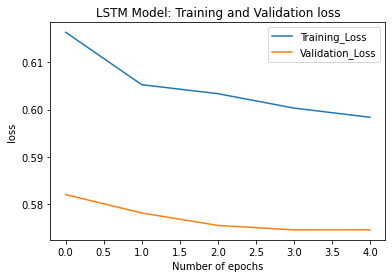

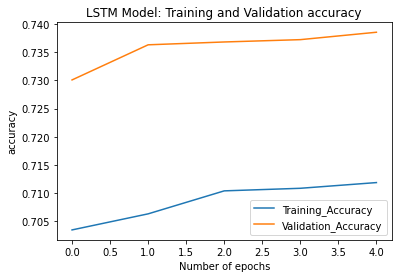

In [30]:
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_metric_curves(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

plot_metric_curves('Training_Loss', 'Validation_Loss', 'loss')
plot_metric_curves('Training_Accuracy', 'Validation_Accuracy', 'accuracy')